In [1]:
import os
import math
import pandas as pd
import numpy as np
import shutil
from glob import glob
from tqdm import tqdm
import yaml
import random

import cv2
import torch
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

# from PIL import Image
# from IPython.display import Image, clear_output

random.seed(42)
np.random.seed(42)

In [2]:
DATASET1 = 'car_detection'
DATASET2 = 'self_driving'
SHAPE1 = (380, 676, 3)
SHAPE2 = (300, 480, 3)

# which dataset to use
DATASET = DATASET1
# shape of images
img_h, img_w, num_channels = SHAPE1

ORIGINAL_DATASET_PATH = f'./{DATASET}_dataset/'
ORIGINAL_IMAGES_PATH = f'./{DATASET}_dataset/images/'

TRAIN_LABELS_PATH = f'./datasets/{DATASET}/labels/train'
VAL_LABELS_PATH = f'./datasets/{DATASET}/labels/val'
TRAIN_IMAGES_PATH = f'./datasets/{DATASET}/images/train'
VAL_IMAGES_PATH = f'./datasets/{DATASET}/images/val'

# if os.path.exists(): 
os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

filenames = glob(ORIGINAL_IMAGES_PATH + '*')
print(len(filenames))

1001


Data Processing

In [3]:
# helper functions

def preprocess(csv_path, shuffle_data=True):

    df = pd.read_csv(csv_path)
    # df.rename(columns={'frame':'image_id'}, inplace=True)
    df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

    if DATASET2 in csv_path:
        # change to 0 index
        df['class_id'] = df['class_id'].apply(lambda x: x-1)
    else:
        df['class_id'] = 0 # only 1 class

    # get x,y,w,h of the bouding boxes
    df['x'] = (df['xmin'] + df['xmax'])/2
    df['y'] = (df['ymin'] + df['ymax'])/2
    df['w'] = df['xmax'] - df['xmin']
    df['h'] = df['ymax'] - df['ymin']
    # normalize
    df['x'] = df['x']/img_w
    df['y'] = df['y']/img_h
    df['w'] = df['w']/img_w
    df['h'] = df['h']/img_h

    if shuffle_data: 
        df = shuffle(df, random_state=42)
        df.reset_index(inplace=True, drop=True)
        
    print(df.head())

    return df


def show_bbox(df, image):

    df_image = df.loc[df['image_id'] == image]
    #print(df_image)

    image_to_show = cv2.imread(ORIGINAL_IMAGES_PATH + f'{image}.jpg')

    for i in df_image.index:
        x = float(df_image.loc[i, 'x'])
        y = float(df_image.loc[i, 'y'])
        w = float(df_image.loc[i, 'w'])
        h = float(df_image.loc[i, 'h'])
        # print(x,y,w,h)

        x1 = int( (x - w/2) * img_w )
        y1 = int( (y - h/2) * img_h )
        x2 = int( (x + w/2) * img_w )
        y2 = int( (y + h/2) * img_h )

        cv2.rectangle(image_to_show, (x1, y1), (x2, y2), (0,0,255), 1)
    
    img_rgb = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()


def create_yolo_dataset(df, split=[0.85, 0.15], overwrite=False):

    if overwrite: clean_dir()

    list_labels = (df[['image_id', 'class_id','x','y','w','h']].to_numpy()).tolist()
    dataset_size = len(df)
    train_size = math.ceil(split[0]*dataset_size)
    val_size = math.floor(split[1]*dataset_size)
    #test_size = dataset_size - train_size - val_size
    print(train_size)
    assert dataset_size == (train_size + val_size)

    for i, row in tqdm(enumerate(list_labels), total=len(df)):
        
        # Split into train, val, or test
        if i < train_size:
            labels_path = TRAIN_LABELS_PATH
            images_path = TRAIN_IMAGES_PATH
        elif i < train_size + val_size:
            labels_path = VAL_LABELS_PATH
            images_path = VAL_IMAGES_PATH
        else:
            pass
          
        image_id = row[0]
        attributes = np.array(row[1:])
        filename = os.path.join(labels_path, f"{image_id}.txt")
        print(attributes)

        # write the label files
        with open(filename, 'ab') as f:
            np.savetxt(f, [attributes], fmt = ['%d', '%f', '%f', '%f', '%f'])

        # copy the image files
        shutil.copy(os.path.join(ORIGINAL_IMAGES_PATH, f"{image_id}.jpg"), images_path)


def clean_dir():
    for path in [TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH, VAL_IMAGES_PATH, VAL_LABELS_PATH]:
        # try:
        #     shutil.rmtree(path)
        # except OSError as e:
        #     print("Error: %s : %s" % (path, e.strerror))
        os.system(f'rm -rf {path}/*')


def generate_yaml(dataset, classes):

    paths = dict(
        path  =  f'../datasets/{dataset}',
        train =  'images/train',
        val   =  'images/val',
        test  =  'images/test'
        )

    with open(f'{dataset}_autogen.yaml', 'w') as outfile:
        yaml.dump(paths, outfile)

    names = dict(names = classes)
    with open(f'{dataset}_autogen.yaml', 'a') as outfile:
        yaml.dump(names, outfile)


Generate YOLO dataset

In [4]:
csv_path = ORIGINAL_DATASET_PATH + 'labels.csv'
df = preprocess(csv_path)
print(len(df))

      image_id        xmin        ymin        xmax        ymax  class_id  \
0  vid_4_17540  250.931983  183.611647  433.872648  252.080116         0   
1   vid_4_6360  607.030391  176.275740  676.000000  218.334942         0   
2  vid_4_12300  168.266281  204.152188  327.238784  253.058237         0   
3  vid_4_21240  596.758321  180.677284  676.000000  235.941120         0   
4  vid_4_13640  327.238784  179.210103  359.033285  213.444337         0   

          x         y         w         h  
0  0.506512  0.573279  0.270622  0.180180  
1  0.948987  0.519225  0.102026  0.110682  
2  0.366498  0.601593  0.235166  0.128700  
3  0.941389  0.548182  0.117221  0.145431  
4  0.507598  0.516651  0.047033  0.090090  
559


Image ID: vid_4_26420


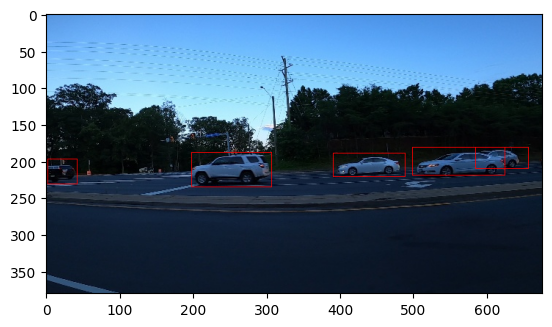

In [5]:
# show a sample
index = list(set(df.image_id))
sample_image = random.choice(index)
#sample_image = list(df_train.image_id)[3]
print("Image ID: %s"%(sample_image))
#img = cv2.imread(f'./self_driving_dataset/images/{sample_image}.jpg')

show_bbox(df, sample_image)

In [30]:
create_yolo_dataset(df, overwrite=True)

476


100%|██████████| 559/559 [00:00<00:00, 5587.47it/s]

[0.         0.5065123  0.57327864 0.27062229 0.18018018]
[0.         0.94898698 0.51922458 0.10202605 0.11068211]
[0.         0.36649783 0.60159266 0.23516643 0.12870013]
[0.         0.94138929 0.54818211 0.11722142 0.14543115]
[0.         0.50759768 0.51665058 0.04703329 0.09009009]
[0.         0.69211288 0.58164414 0.25397974 0.20720721]
[0.         0.85600579 0.50378057 0.14037627 0.09266409]
[0.         0.16208394 0.58357465 0.21128799 0.14929215]
[0.         0.802622   0.51866095 0.0975965  0.08419689]
[0.         0.51736614 0.56298263 0.17655572 0.11068211]
[0.         0.55680174 0.57070463 0.20477569 0.14671815]
[0.         0.81041968 0.52051158 0.21418234 0.12612613]
[0.         0.42836469 0.54625161 0.12301013 0.1029601 ]
[0.         0.08068017 0.55654762 0.14544139 0.10810811]
[0.         0.89182344 0.51214607 0.21635311 0.16859717]
[0.         0.92402315 0.5404601  0.15195369 0.16859717]
[0.         0.4605644  0.58872265 0.23371925 0.15958816]
[0.         0.7959479  0.531451

In [32]:
# classes = [ 'car',
#             'truck',
#             'pedestrian',
#             'bicyclist',
#             'light']

classes = {0 : 'car'}
generate_yaml('car_detection', classes)

In [ ]:
# def split_dataset(animal, image_names, train_size, val_size):
#     for i, image_name in enumerate(image_names):
#         # Label filename
#         label_name = image_name.replace('.jpg', '.txt')
        
#         # Split into train, val, or test
#         if i < train_size:
#             split = 'train'
#         elif i < train_size + val_size:
#             split = 'val'
#         else:
#             split = 'test'
        
#         # Source paths
#         source_image_path = f'download/{animal}/images/{image_name}'
#         source_label_path = f'download/{animal}/darknet/{label_name}'

#         # Destination paths
#         target_image_folder = f'data/images/{split}'
#         target_label_folder = f'data/labels/{split}'

#         # Copy files
#         shutil.copy(source_image_path, target_image_folder)
#         shutil.copy(source_label_path, target_label_folder)

# # Cat data
# split_dataset('cat', cat_images, train_size=400, val_size=50)

# # Dog data (reduce the number by 1 for each set due to three duplicates)
# split_dataset('dog', dog_images, train_size=399, val_size=49) 